In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io
import random
import tqdm
import torch as tc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
! pip install torchsummary
from torchsummary import summary
import gc
from google.colab import drive
import time

In [2]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/Brain_tumor/newDataset"

path_testing = path + "/test"
path_training = path + "/train"

list_train = os.listdir(path_training)
list_test = os.listdir(path_testing)
print(list_train)
print(list_test)

Mounted at /content/drive
['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']
['pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']


In [3]:
# training dataset 
train_glioma = path_training + "/glioma_tumor"
train_meningioma = path_training + "/meningioma_tumor"
train_pituitary = path_training + "/pituitary_tumor"

print(f'train glioma: {len(os.listdir(train_glioma))}')
print(f'train meningioma: {len(os.listdir(train_meningioma))}')
print(f'train pituitary: {len(os.listdir(train_pituitary))}')

# testing dataset
test_glioma = path_testing + "/glioma_tumor"
test_meningioma = path_testing + "/meningioma_tumor"
test_pituitary = path_testing + "/pituitary_tumor"

print(f'test glioma: {len(os.listdir(test_glioma))}')
print(f'test meningioma: {len(os.listdir(test_meningioma))}')
print(f'test pituitary: {len(os.listdir(test_pituitary))}')

train glioma: 1212
train meningioma: 602
train pituitary: 790
test glioma: 214
test meningioma: 106
test pituitary: 140


In [4]:
class TumorDataset(tc.utils.data.Dataset):
  def __init__(self, image_paths, image_labels, transforms):
    self.image_paths = image_paths
    self.labels = image_labels
    self.transforms = transforms

  def __getitem__(self,i):
    image = plt.imread(self.image_paths[i])
    label = self.labels[i]
    image = self.transforms(image)
    return image, label

  def __len__(self):
    return len(self.image_paths)

def labels(filename, main_path):
    if filename[len(main_path)+1] == "g":
        label = 0
    elif filename[len(main_path)+1] == "m":
        label = 1
    elif filename[len(main_path)+1] == "p":
        label = 2

    return label

classes = ['Glioma', 'Meningioma', 'Pituitary']

In [5]:
train_path = [path_training + '/' + i + '/' + img 
                    for i in os.listdir(path_training) 
                    for img in os.listdir(path_training + '/' + i)
                    ]

test_path = [path_testing + '/' + i + '/' + img 
                  for i in os.listdir(path_testing) 
                  for img in os.listdir(path_testing + '/' + i)
                  ]

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.Resize((224,224)),
                                transforms.GaussianBlur(kernel_size=5, sigma=(1, 1)),
                                ])

augmentation = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                   transforms.Resize((224,224)),
                                   transforms.GaussianBlur(kernel_size=5, sigma=(1, 1)),
                                   transforms.RandomHorizontalFlip(p=1),
                                   ])

augmentation2 = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                    transforms.Resize((224,224)),
                                    transforms.GaussianBlur(kernel_size=5, sigma=(1, 1)),
                                    transforms.RandomRotation(degrees=(90,90)),
                                    ])

In [6]:
train_label = [labels(data, path_training) for data in train_path]
test_label = [labels(data, path_testing) for data in test_path]

print(f"Train: {len(train_label)}")
print(f"Test: {len(test_label)}")

#Validation dataset 
training_path, validation_path, training_label, validation_label = train_test_split(train_path, train_label, test_size=0.05, random_state = 1, stratify=train_label) 
print(f"Validation: {len(validation_path)}")
print(f"Train after split: {len(training_path)}")

Train: 2604
Test: 460
Validation: 131
Train after split: 2473


In [7]:
print("Validation set:\n")
for i in range(3):
  print(classes[i], '-', len(np.where(np.array(validation_label) == i)[0]))

Validation set:

Glioma - 61
Meningioma - 30
Pituitary - 40


In [8]:
print("Training set:\n")
for i in range(3):
  print(classes[i], '-', len(np.where(np.array(training_label) == i)[0]))

Training set:

Glioma - 1151
Meningioma - 572
Pituitary - 750


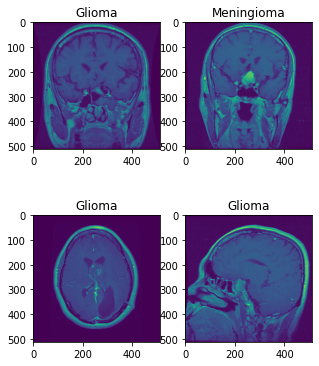

In [9]:
# random image from train Dataset (before resizing)
plt.figure(figsize=(5,6.5))
for i in range(4):
  n = random.randint(0, len(training_path)-1)
  image = plt.imread(training_path[n])
  plt.subplot(2,2,i+1)
  plt.imshow(image)
  plt.title(classes[train_label[n]])
plt.show()

In [35]:
augmentation_train = TumorDataset(training_path, training_label, transforms=augmentation)
augmentation_train2 = TumorDataset(training_path, training_label, transforms=augmentation2)

train_dataset = TumorDataset(training_path, training_label, transforms=transform)
test_dataset = TumorDataset(test_path, test_label, transforms=transform)
validation_dataset = TumorDataset(validation_path, validation_label, transforms=transform)

batch_size = 4
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

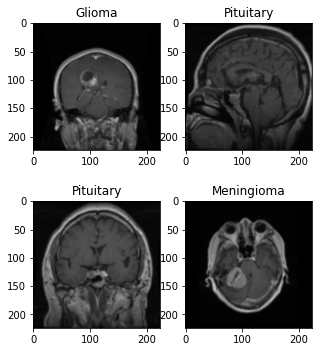

In [36]:
# random image from train DataLoader (after transforms)
plt.figure(figsize=(5,6))
for i in range(4):
  for images, labels in train_dataloader:
    plt.subplot(2,2,i+1)
    plt.imshow(images[0, :, :, :].numpy().swapaxes(0, 1).swapaxes(1, 2))
    plt.title(classes[labels[0]])
    break
plt.show()

In [37]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        tc.nn.init.normal_(m.weight, mean=0, std=0.01)

In [38]:
class FineTuneModel(nn.Module):
    def __init__(self, original_model, num_classes, is_requires_grad = False, is_first_learning = True):
        super(FineTuneModel, self).__init__()

        self.features = original_model.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.classifier.apply(init_weights)
        for p in self.features.parameters():
          p.requires_grad = is_requires_grad
          
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = tc.flatten(x, 1)
        x = self.classifier(x)
        return x

In [39]:
model = torchvision.models.vgg16(pretrained=True)
model = FineTuneModel(model, 3)
device = "cuda:0"     # or "cpu"
model = model.to(device)    # move the model to GPU
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [40]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [41]:
def fit(num_epoch, cost_function, optimizer, path):
  train_losses = []
  train_accuracy = []
  eval_losses = []
  eval_accuracy = []
  best_accuracy = 0

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0 
    print(f'Epoch: {epoch+1}')

    model.train()
    for image, label in tqdm.tqdm(train_dataloader, position=0, leave=True):  
      image = image.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      results = model(image)
      loss = cost_function(results, label)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = results.max(1)
      total += label.size(0)
      correct += predicted.eq(label).sum().item()

    train_loss = running_loss / len(train_dataloader)
    accuracy = 100. * correct / total
    
    train_accuracy.append(accuracy)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss, accuracy))


    model.eval()
    with tc.no_grad():
      for image, label in tqdm.tqdm(validation_dataloader, position=0, leave=True):
        
        image = image.to(device)
        label = label.to(device)

        results = model(image)
        val_loss = cost_function(results, label)

        running_val_loss += val_loss.item()
        _, predicted_val = results.max(1)
        total_val += labels.size(0)
        correct_val += predicted_val.eq(label).sum().item()

    val_loss = running_val_loss / len(validation_dataloader)
    accuracy_val = 100. * correct_val / total_val
    if accuracy_val >= best_accuracy:
      tc.save(model.state_dict(), path)
      best_accuracy = accuracy_val

    eval_losses.append(val_loss)
    eval_accuracy.append(accuracy_val)

    print('Validation Loss: %.3f | Accuracy: %.3f'%(val_loss, accuracy_val))

    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

  end = time.time()
  print(f"Training time: {(end-start)/60:.3f} minutes")

  return train_accuracy, eval_accuracy, train_losses, eval_losses

In [42]:
def plot_accuracy(train_accuracy, eval_accuracy):
  plt.plot(train_accuracy,'.-')
  plt.plot(eval_accuracy,'.-')
  plt.xlabel('epoch')
  plt.ylabel('accuracy [%]')
  plt.legend(['Train','Valid'], loc="lower right")
  plt.title("Model accuracy")
  plt.show()

def plot_losses(train_losses, eval_losses):
  plt.plot(train_losses,'.-')
  plt.plot(eval_losses,'.-')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Valid'])
  plt.title("Model loss")
  plt.show()

In [43]:
def evaluate(model, test_dataloader):
  model.eval()
  actuals = []
  predictions = []

  with tc.no_grad():
    for image, label in test_dataloader:    
      image = image.to(device)                     # GPU
      label = label.to(device)
      results = model(image)             
      prediction = results.argmax(dim=1, keepdim=True)     
      actuals.extend(label.view_as(prediction))        #[]
      predictions.extend(prediction)

  actuals = [i.item() for i in actuals]
  predictions = [i.item() for i in predictions]
  return actuals, predictions

In [44]:
def plot_confusion_matrix(conf_matrix):
  plt.figure(figsize=(7,6))
  sns.heatmap(cm, xticklabels=classes, yticklabels=['','',''], annot=True, fmt='.3g',  cmap='YlGnBu')   #Reds
  plt.ylabel('True label \n \n \n    Pituitary                 Meningioma                   Glioma    ')
  plt.xlabel('\n \n  Predicted label') 
  plt.title('Confusion matrix')
  plt.show()

In [45]:
def class_probabilities(model, number_of_class):
  model.eval()
  actuals = []
  probabilities = []
  with tc.no_grad():
    for image, label in test_dataloader:
      image = image.to(device)
      label = label.to(device)
      results = model(image)
      prediction = results.argmax(dim=1, keepdim=True)
      actuals.extend(label.view_as(prediction) == number_of_class)
      probabilities.extend(np.exp(results.cpu()[:, number_of_class]))

  actuals = [i.item() for i in actuals]
  probabilities = [i.item() for i in probabilities]
  
  fpr, tpr, _ = roc_curve(actuals, probabilities)
  roc_auc = auc(fpr, tpr)

  return fpr, tpr, roc_auc

In [46]:
optimizer = tc.optim.Adam(model.parameters(), lr=0.0001)
cost_function = nn.CrossEntropyLoss()
num_epochs = 4
path = '/content/drive/My Drive/Brain_tumor/newDataset/model/train_only_classification_layers.pth'

early_stopping = EarlyStopping()
start = time.time()

train_accuracy, eval_accuracy, train_losses, eval_losses = fit(num_epochs, cost_function, optimizer, path)

Epoch: 1


100%|██████████| 619/619 [02:21<00:00,  4.37it/s]


Train Loss: 0.580 | Accuracy: 78.205


100%|██████████| 33/33 [00:05<00:00,  6.57it/s]


Validation Loss: 0.640 | Accuracy: 77.273
Epoch: 2


100%|██████████| 619/619 [02:23<00:00,  4.32it/s]


Train Loss: 0.299 | Accuracy: 89.325


100%|██████████| 33/33 [00:05<00:00,  6.47it/s]


Validation Loss: 0.532 | Accuracy: 79.545
Epoch: 3


100%|██████████| 619/619 [02:24<00:00,  4.27it/s]


Train Loss: 0.185 | Accuracy: 93.247


100%|██████████| 33/33 [00:05<00:00,  6.36it/s]


Validation Loss: 0.316 | Accuracy: 87.121
Epoch: 4


100%|██████████| 619/619 [02:25<00:00,  4.26it/s]


Train Loss: 0.143 | Accuracy: 95.067


100%|██████████| 33/33 [00:05<00:00,  6.43it/s]


Validation Loss: 0.293 | Accuracy: 87.121
Training time: 10.104 minutes


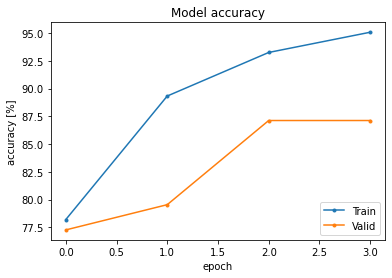

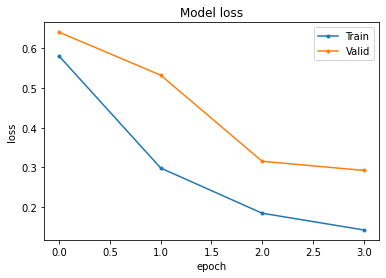

In [47]:
plot_accuracy(train_accuracy, eval_accuracy)
plot_losses(train_losses, eval_losses)

In [48]:
#model.load_state_dict(tc.load(path))
actuals, predictions = evaluate(model, test_dataloader)

cm = confusion_matrix(actuals, predictions)
print("Confusion Matrix : ")
print(cm)
print('Recall score: %f' % recall_score(actuals, predictions, average='macro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print(classification_report(actuals, predictions)) 

Confusion Matrix : 
[[207   7   0]
 [ 17  87   2]
 [  0   2 138]]
Recall score: 0.924586
Precision score: 0.938690
Accuracy score: 0.939130
F1 score: 0.930769
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       214
           1       0.91      0.82      0.86       106
           2       0.99      0.99      0.99       140

    accuracy                           0.94       460
   macro avg       0.94      0.92      0.93       460
weighted avg       0.94      0.94      0.94       460



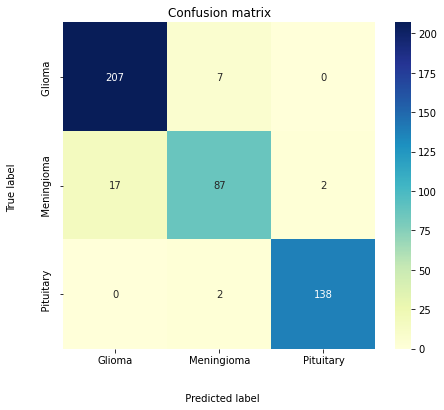

In [49]:
plot_confusion_matrix(cm)

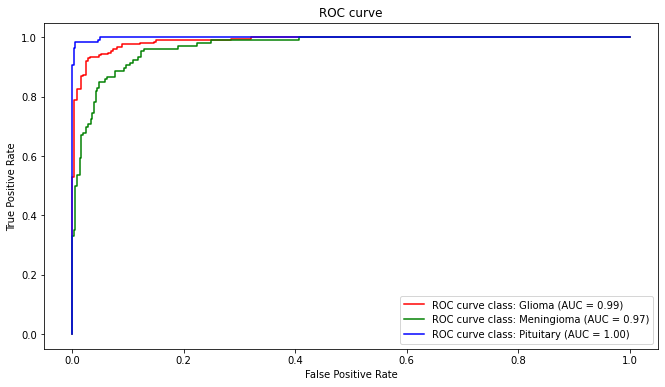

In [50]:
fpr_dict ={}
tpr_dict = {}
roc_auc_dict = {}
for i in range(3):
  fpr, tpr, roc_auc = class_probabilities(model, i)
  fpr_dict[i] = fpr
  tpr_dict[i] = tpr
  roc_auc_dict[i] = roc_auc

colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=[11,6])
for i in range(3):
  plt.plot(fpr_dict[i], tpr_dict[i], color = colors[i], label='ROC curve class: ' + classes[i] + ' (AUC = %0.2f)' % roc_auc_dict[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

In [51]:
model = torchvision.models.vgg16(pretrained=False)
model = FineTuneModel(model, 3, True)
model.load_state_dict(tc.load(path))
device = "cuda:0"     # or "cpu"
model = model.to(device)    # move the model to GPU
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [52]:
optimizer = tc.optim.Adam(model.parameters(), lr=0.00001)
cost_function = nn.CrossEntropyLoss()
num_epochs = 50
path = '/content/drive/My Drive/Brain_tumor/newDataset/model/train_only_classification_layers+train_all_model.pth'

train_accuracy, eval_accuracy, train_losses, eval_losses = fit(num_epochs, cost_function, optimizer, path)

Epoch: 1


100%|██████████| 619/619 [04:01<00:00,  2.56it/s]


Train Loss: 0.078 | Accuracy: 96.765


100%|██████████| 33/33 [00:05<00:00,  6.44it/s]


Validation Loss: 0.231 | Accuracy: 90.909
Epoch: 2


100%|██████████| 619/619 [03:59<00:00,  2.58it/s]


Train Loss: 0.033 | Accuracy: 98.868


100%|██████████| 33/33 [00:04<00:00,  6.65it/s]


Validation Loss: 0.115 | Accuracy: 93.939
Epoch: 3


100%|██████████| 619/619 [04:00<00:00,  2.57it/s]


Train Loss: 0.041 | Accuracy: 98.746


100%|██████████| 33/33 [00:05<00:00,  6.52it/s]


Validation Loss: 0.220 | Accuracy: 92.424
INFO: Early stopping counter 1 of 10
Epoch: 4


100%|██████████| 619/619 [04:01<00:00,  2.56it/s]


Train Loss: 0.009 | Accuracy: 99.555


100%|██████████| 33/33 [00:04<00:00,  6.62it/s]


Validation Loss: 0.265 | Accuracy: 90.909
INFO: Early stopping counter 2 of 10
Epoch: 5


100%|██████████| 619/619 [04:00<00:00,  2.57it/s]


Train Loss: 0.008 | Accuracy: 99.757


100%|██████████| 33/33 [00:05<00:00,  6.39it/s]


Validation Loss: 0.262 | Accuracy: 90.152
INFO: Early stopping counter 3 of 10
Epoch: 6


100%|██████████| 619/619 [04:01<00:00,  2.57it/s]


Train Loss: 0.019 | Accuracy: 99.313


100%|██████████| 33/33 [00:05<00:00,  6.29it/s]


Validation Loss: 0.225 | Accuracy: 93.939
INFO: Early stopping counter 4 of 10
Epoch: 7


100%|██████████| 619/619 [04:03<00:00,  2.54it/s]


Train Loss: 0.011 | Accuracy: 99.677


100%|██████████| 33/33 [00:05<00:00,  6.46it/s]


Validation Loss: 0.166 | Accuracy: 94.697
INFO: Early stopping counter 5 of 10
Epoch: 8


100%|██████████| 619/619 [04:04<00:00,  2.54it/s]


Train Loss: 0.001 | Accuracy: 100.000


100%|██████████| 33/33 [00:05<00:00,  6.41it/s]


Validation Loss: 0.152 | Accuracy: 96.970
INFO: Early stopping counter 6 of 10
Epoch: 9


100%|██████████| 619/619 [04:01<00:00,  2.56it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 33/33 [00:05<00:00,  6.51it/s]


Validation Loss: 0.154 | Accuracy: 96.212
INFO: Early stopping counter 7 of 10
Epoch: 10


100%|██████████| 619/619 [04:00<00:00,  2.57it/s]


Train Loss: 0.000 | Accuracy: 100.000


100%|██████████| 33/33 [00:05<00:00,  6.38it/s]


Validation Loss: 0.200 | Accuracy: 96.212
INFO: Early stopping counter 8 of 10
Epoch: 11


100%|██████████| 619/619 [04:01<00:00,  2.56it/s]


Train Loss: 0.037 | Accuracy: 98.787


100%|██████████| 33/33 [00:05<00:00,  6.40it/s]


Validation Loss: 0.225 | Accuracy: 90.152
INFO: Early stopping counter 9 of 10
Epoch: 12


100%|██████████| 619/619 [04:02<00:00,  2.56it/s]


Train Loss: 0.025 | Accuracy: 99.110


100%|██████████| 33/33 [00:05<00:00,  6.46it/s]

Validation Loss: 0.127 | Accuracy: 94.697
INFO: Early stopping counter 10 of 10
INFO: Early stopping
Training time: 60.872 minutes


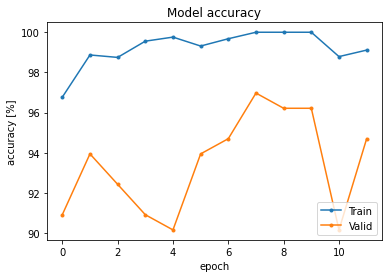

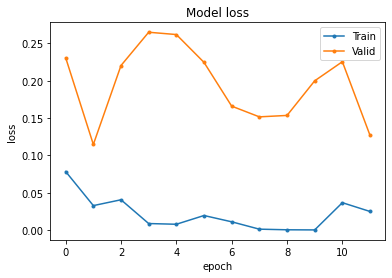

In [53]:
plot_accuracy(train_accuracy, eval_accuracy)
plot_losses(train_losses, eval_losses)

In [58]:
model.load_state_dict(tc.load(path))
actuals, predictions = evaluate(model, test_dataloader)

cm = confusion_matrix(actuals, predictions)
print("Confusion Matrix : ")
print(cm)
print('Recall score: %f' % recall_score(actuals, predictions, average='macro'))
print('Precision score: %f' % precision_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print(classification_report(actuals, predictions)) 

Confusion Matrix : 
[[209   5   0]
 [  1 102   3]
 [  0   3 137]]
Recall score: 0.972490
Precision score: 0.967027
Accuracy score: 0.973913
F1 score: 0.969622
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       214
           1       0.93      0.96      0.94       106
           2       0.98      0.98      0.98       140

    accuracy                           0.97       460
   macro avg       0.97      0.97      0.97       460
weighted avg       0.97      0.97      0.97       460



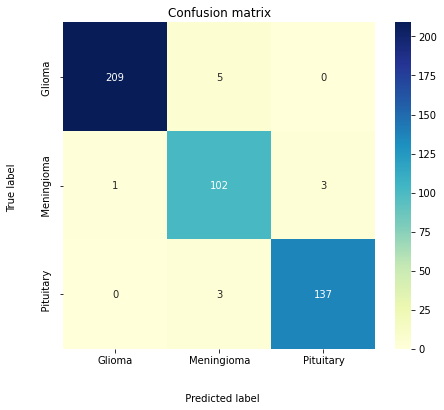

In [59]:
plot_confusion_matrix(cm)

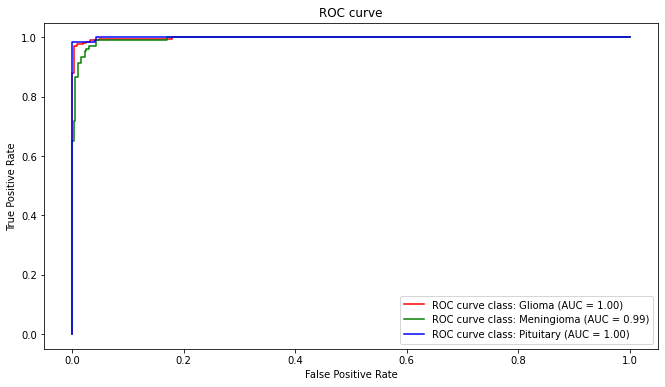

In [60]:
fpr_dict ={}
tpr_dict = {}
roc_auc_dict = {}
for i in range(3):
  fpr, tpr, roc_auc = class_probabilities(model, i)
  fpr_dict[i] = fpr
  tpr_dict[i] = tpr
  roc_auc_dict[i] = roc_auc

colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=[11,6])
for i in range(3):
  plt.plot(fpr_dict[i], tpr_dict[i], color = colors[i], label='ROC curve class: ' + classes[i] + ' (AUC = %0.2f)' % roc_auc_dict[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()